## Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса. 



### Описание данных
Данные состоят из нескольких файлов, полученных из разных источников:
* data_arc_new.csv — данные об электродах;
* data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
* data_gas_new.csv — данные о продувке сплава газом;
* data_temp_new.csv — результаты измерения температуры;
* data_wire_new.csv — данные о проволочных материалах (объём);
* data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

In [1]:
import pandas as pd
import numpy as np
#import re
import time
from scipy.optimize import curve_fit 

import seaborn as sns
from datetime import datetime as dt
from matplotlib import pyplot as plt

from pandas.plotting import scatter_matrix

In [2]:
# Параметры обучения
RANDOM_STATE = 29102024
TEST_SIZE = 0.25
N = 4  # Количество выводимых строк
N_LINES = 70

In [3]:
def load_csv(file, fallback_path):#, sep=',', decimal='.'):
    try:
        return pd.read_csv(file)#, sep=sep, decimal=decimal)
    except FileNotFoundError:
        return pd.read_csv(fallback_path)#, sep=sep, decimal=decimal)

In [4]:
# Функция, выводящая основную информацию о загруженной таблице
def information(file, name):
    # Отображение формы данных (количество строк и столбцов)
    print(f"Форма данных {name}:")
    print(file.shape)
    print("\n" + "-"*N_LINES + "\n")

# Отображение случайных строк данных, отсортированных по индексу
    print(f"Пример данных {name} :")
    display(file.sample(N).sort_index())
    print("\n" + "-"*N_LINES + "\n")

# Отображение информации о DataFrame
    print(f"Информация о данных {name}:")
    file.info()
    print("\n" + "-"*N_LINES + "\n")

# Отображение количества уникальных значений в каждом столбце
    print(f"Количество уникальных значений из {name}:")
    print(file.nunique())
    print("\n" + "-"*N_LINES + "\n")
    
    if "id" in file.columns:
        diplay(f"Количество дубликатов из {name}:")
        display(file.duplicated().sum())
        print("\n" + "-"*N_LINES + "\n")
        file1 = file.drop(columns=['id'])
        display(f"Количество дубликатов в {name} без учёта 'id':")
        display(file1.duplicated().sum())
        print("-"*N_LINES)
        
    else:
        display(f"Количество дубликатов из {name}:")
        display(file.duplicated().sum())
        print("-"*N_LINES) 

    print(f"Количество пропусков из {name}:")
    display(file.isna().sum())
#    print("\n" + "-"*N_LINES + "\n")

    if (file.isna().sum() !=0).sum() > 1:
        print("-"*N_LINES)
        print(f"Карта пропусков из {name}:")
        colours = ['#000099', '#ffff00'] 
        sns.heatmap(file.isnull(), cmap=sns.color_palette(colours))
        
        col_mis = []
        proz = []
        sm = []

        for col in file.columns:
            clv = file[col].isna().sum()
            missing = round(np.mean(file[col].isnull())*100, 2)
            if missing != 0:
                col_mis.append(col)
                proz.append(missing) 
                sm.append(clv)
    
        percentile_list = pd.DataFrame({'lst1Title': col_mis, 'lst2Title': proz})

        percentile_list = percentile_list.sort_values(by='lst2Title', ascending=True)
        s = percentile_list.shape[0]/4.5
        percentile_list.plot.barh(x='lst1Title', y='lst2Title',  grid=True,  legend = False,
             title='Процент пропусков по столбцам', color='black', figsize=(8, s))
        plt.ylabel("Столбцы", fontsize=9)
        #plt.xlabel("Проценты", fontsize=9)
        print("-"*N_LINES) 

        print(f"Общий процент пропусков по всей таблице: ", 
              round(sum(sm)*100/(file.shape[0]*file.shape[1]), 3))

In [5]:
# Функция, выводящая по численным столбцам статичсические данные
def describe_main(df):
    for k in df.select_dtypes(exclude='object').columns.tolist():
        print(k)
        display(df.describe())
        print(N_LINES*"-")
        print()

In [6]:
def block_diagram(name, lst, c = 20):
#строит несколько блочных диаграмм фрейма "name" по данным числового столбца   b, 
#сгруппированного по признакам столбца а. Численные данные столбца b разбиваются наколичество
#корзин с. 

    for u in lst:

        name[u].plot(kind='hist', y='u', histtype='step',
                     range=(name[u].min(), name[u].max()), bins=c,
        linewidth=4, alpha=0.9, grid=True, figsize=(10, 5), label='raw')
        plt.title(f"Распределение мощностей ", fontsize=20, 
                  fontname='Times New Roman')
        plt.xlabel('Значение мощности', color='black')
        plt.ylabel('Частота',color='black')
    plt.legend(lst)

In [7]:
def dens_diagram(name, lst):
#строит несколько блочных диаграмм фрейма "name" по данным числового столбца   b, 
#сгруппированного по признакам столбца а. Численные данные столбца b разбиваются наколичество
#корзин с. 
    clr = ['darkgreen', 'darkblue', 'darkorange']
    plt.figure(figsize=(13, 6))
    plt.title(f"Распределение мощностей ", fontsize=20, fontname='Times New Roman')
    plt.xlabel('Значение мощности', color='black')
    plt.grid(True)
    for u in range(len(lst)):
        fig = sns.kdeplot(name[lst[u]], color=clr[u], legend=False, shade=True)
    plt.legend(lst)   

### 1. Загрузка и первичный обзор данных.

1.1. Загружаем файл "об электродах" 🤣🤣🤣

In [8]:
data_arc = load_csv('data_arc_new.csv', "https://code.s3.yandex.net/datasets/data_arc_new.csv")
information(data_arc, "таблицы параметры нагрева 'data_arc'")

Форма данных таблицы параметры нагрева 'data_arc':
(14876, 5)

----------------------------------------------------------------------

Пример данных таблицы параметры нагрева 'data_arc' :


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4229,909,2019-06-07 15:35:38,2019-06-07 15:38:51,0.569443,0.493613
4555,984,2019-06-10 10:50:52,2019-06-10 10:51:53,1.067468,0.774704
5585,1214,2019-06-18 08:31:20,2019-06-18 08:32:22,0.338146,0.288641
8213,1786,2019-07-08 16:54:41,2019-07-08 16:56:35,0.341070,0.236712



----------------------------------------------------------------------

Информация о данных таблицы параметры нагрева 'data_arc':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

----------------------------------------------------------------------

Количество уникальных значений из таблицы параметры нагрева 'data_arc':
key                      3214
Начало нагрева дугой    14876
Конец нагрева дугой     14876
Активная мощность       13846
Реактивная мощность     14707
dtype: int64

-------------------------------

"Количество дубликатов из таблицы параметры нагрева 'data_arc':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы параметры нагрева 'data_arc':


key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [9]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'],
                                                    format='%Y-%m-%d %H:%M:%S')

data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'],
                                                   format='%Y-%m-%d %H:%M:%S')

1.2. Загружаем данные объёме подачи сыпучих материалов.

Форма данных таблицы об объёме сыпучих материалов 'data_bulk':
(3129, 16)

----------------------------------------------------------------------

Пример данных таблицы об объёме сыпучих материалов 'data_bulk' :


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1320,1372,NaN,NaN,141.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1895,1958,NaN,NaN,31.0,NaN,NaN,175.0,NaN,NaN,NaN,NaN,NaN,310.0,NaN,180.0,202.0
1970,2039,NaN,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,162.0,NaN,107.0,206.0
2018,2089,NaN,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



----------------------------------------------------------------------

Информация о данных таблицы об объёме сыпучих материалов 'data_bulk':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

------------

"Количество дубликатов из таблицы об объёме сыпучих материалов 'data_bulk':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы об объёме сыпучих материалов 'data_bulk':


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

----------------------------------------------------------------------
Карта пропусков из таблицы об объёме сыпучих материалов 'data_bulk':
----------------------------------------------------------------------
Общий процент пропусков по всей таблице:  71.461


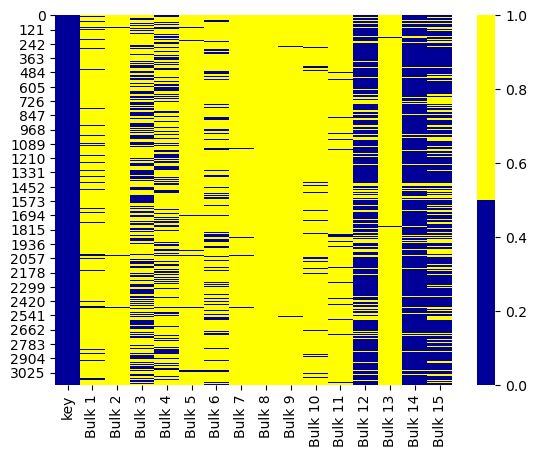

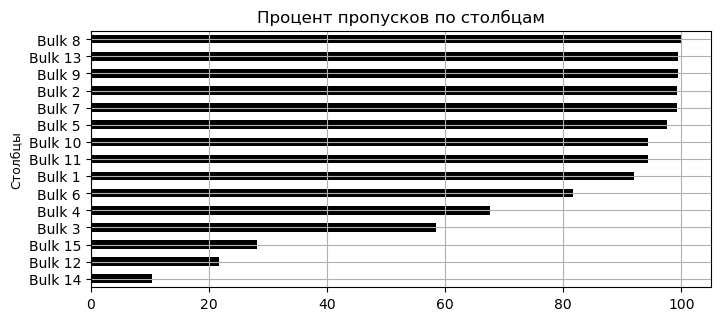

In [10]:
data_bulk = load_csv('data_bulk_new.csv', 
                         "https://code.s3.yandex.net/datasets/data_arc_new.csv")
information(data_bulk, "таблицы об объёме сыпучих материалов 'data_bulk'")

1.3. Загружаем данные о времени подачи сыпучих материалов, очевидно раскислителей.

Форма данных таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv':
(3129, 16)

----------------------------------------------------------------------

Пример данных таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv' :


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
884,920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-08 02:36:55,NaN,2019-06-08 02:23:41,2019-06-08 02:06:38
1169,1217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-18 11:39:40,NaN
1472,1528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-29 22:45:50,NaN
3028,3137,NaN,NaN,2019-09-03 02:23:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-03 02:38:01,NaN,2019-09-03 02:33:57,2019-09-03 02:27:51



----------------------------------------------------------------------

Информация о данных таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

-----------------

"Количество дубликатов из таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv':


key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

----------------------------------------------------------------------
Карта пропусков из таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv':
----------------------------------------------------------------------
Общий процент пропусков по всей таблице:  71.461


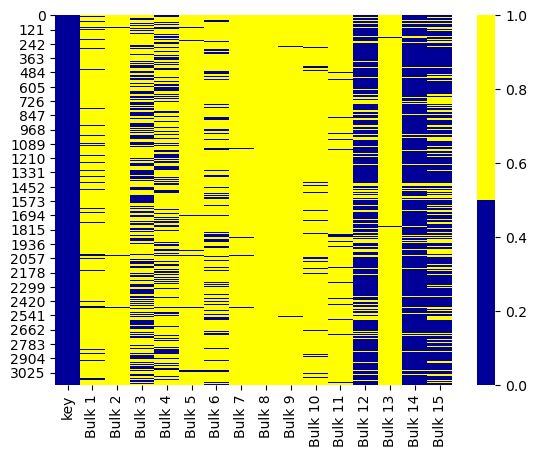

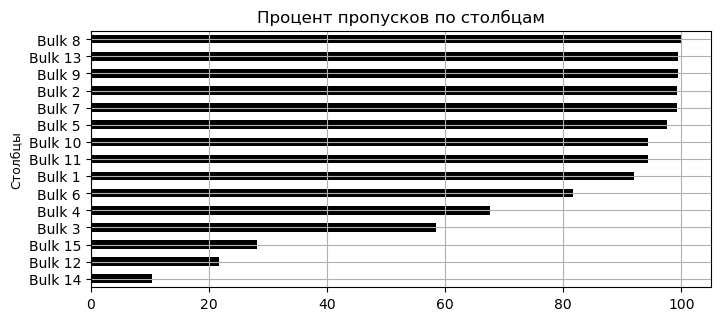

In [11]:
data_bulk_time = load_csv('data_bulk_time_new.csv', 
                         "https://code.s3.yandex.net/datasets/data_bulk_time_new.csv")
information(data_bulk_time, "таблицы об объёме сыпучих материалов 'data_bulk_time_new.csv'")

In [12]:
for i in data_bulk_time.columns:
    if i != 'key':
        data_bulk_time[i] = pd.to_datetime(data_bulk_time[i], format='%Y-%m-%d %H:%M:%S')

1.4. Загружаем данные о продувке расплава газом.

In [13]:
data_gas = load_csv('data_gas_new.csv', 
                         "https://code.s3.yandex.net/datasets/data_gas_new.csv")
information(data_gas, "таблицы о продувке газом 'data_gas_new.csv'")

Форма данных таблицы о продувке газом 'data_gas_new.csv':
(3239, 2)

----------------------------------------------------------------------

Пример данных таблицы о продувке газом 'data_gas_new.csv' :


,key,Газ 1
48,49,10.441228
554,557,10.350551
753,756,2.312542
1941,1944,8.320681



----------------------------------------------------------------------

Информация о данных таблицы о продувке газом 'data_gas_new.csv':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

----------------------------------------------------------------------

Количество уникальных значений из таблицы о продувке газом 'data_gas_new.csv':
key      3239
Газ 1    3239
dtype: int64

----------------------------------------------------------------------



"Количество дубликатов из таблицы о продувке газом 'data_gas_new.csv':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы о продувке газом 'data_gas_new.csv':


key      0
Газ 1    0
dtype: int64

1.5. Загружаем данные замера температуры.

In [14]:
data_temp = load_csv('data_temp_new.csv', 
                         "https://code.s3.yandex.net/datasets/data_temp_new.csv")
information(data_temp, "таблицы замера температуры 'data_temp_new.csv'")

Форма данных таблицы замера температуры 'data_temp_new.csv':
(18092, 3)

----------------------------------------------------------------------

Пример данных таблицы замера температуры 'data_temp_new.csv' :


,key,Время замера,Температура
2321,414,2019-05-19 07:22:02,1590.0
5758,1024,2019-06-11 23:08:03,1583.0
8807,1574,2019-07-01 16:10:43,1582.0
10933,1950,2019-07-21 02:07:54,1594.0



----------------------------------------------------------------------

Информация о данных таблицы замера температуры 'data_temp_new.csv':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB

----------------------------------------------------------------------

Количество уникальных значений из таблицы замера температуры 'data_temp_new.csv':
key              3216
Время замера    18092
Температура       172
dtype: int64

----------------------------------------------------------------------



"Количество дубликатов из таблицы замера температуры 'data_temp_new.csv':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы замера температуры 'data_temp_new.csv':


key                0
Время замера       0
Температура     3427
dtype: int64

In [15]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')

1.6. Загружаем данные о введении проволочных материалов, очевидно, легирующих добавок.

Форма данных таблицы об объёме проволочых материалов 'data_wire_new.csv':
(3081, 10)

----------------------------------------------------------------------

Пример данных таблицы об объёме проволочых материалов 'data_wire_new.csv' :


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
667,704,144.377997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1331,1402,140.072403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2465,2592,35.031360,40.052479,NaN,NaN,NaN,0.03432,NaN,NaN,NaN
2480,2607,102.123840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



----------------------------------------------------------------------

Информация о данных таблицы об объёме проволочых материалов 'data_wire_new.csv':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

----------------------------------------------------------------------

Количество уникальных значений из таблицы об объёме проволочых материалов 'data_wire_new.csv':
key       3081
Wire 1    2251
Wire 2     713
Wire 3      56
Wire 4      14


"Количество дубликатов из таблицы об объёме проволочых материалов 'data_wire_new.csv':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы об объёме проволочых материалов 'data_wire_new.csv':


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

----------------------------------------------------------------------
Карта пропусков из таблицы об объёме проволочых материалов 'data_wire_new.csv':
----------------------------------------------------------------------
Общий процент пропусков по всей таблице:  75.901


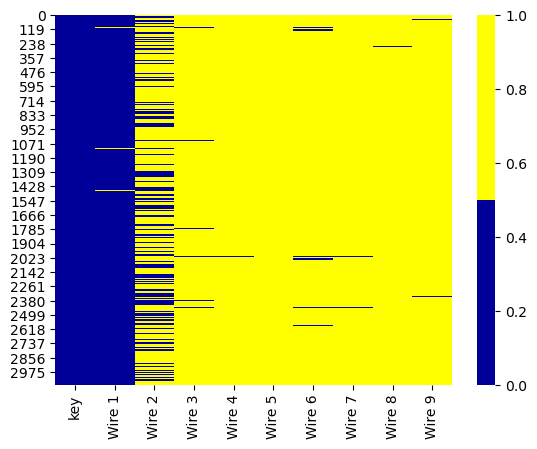

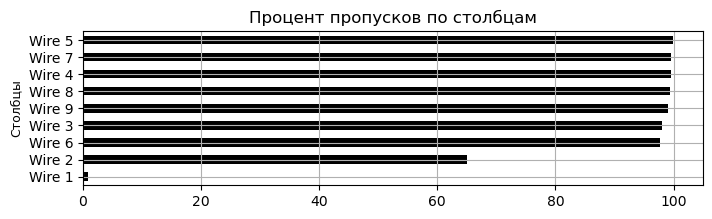

In [16]:
data_wire = load_csv('data_wire_new.csv', 
                         "https://code.s3.yandex.net/datasets/data_wire_new.csv")
information(data_wire, "таблицы об объёме проволочых материалов 'data_wire_new.csv'")

1.7. данные о проволочных материалах (время).

Форма данных таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv':
(3081, 10)

----------------------------------------------------------------------

Пример данных таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv' :


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
874,928,2019-06-08 12:21:44,2019-06-08 12:14:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1501,1580,2019-07-01 20:17:44,2019-07-01 20:10:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2345,2471,2019-08-09 13:27:53,2019-08-09 13:22:09,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-09 13:07:31
2377,2504,2019-08-10 17:43:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



----------------------------------------------------------------------

Информация о данных таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

----------------------------------------------------------------------

Количество уникальных значений из таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv':
key       3081
Wire 1    3055
Wire 2    1079
Wire 3      63

"Количество дубликатов из таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv':"

0

----------------------------------------------------------------------
Количество пропусков из таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv':


key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

----------------------------------------------------------------------
Карта пропусков из таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv':
----------------------------------------------------------------------
Общий процент пропусков по всей таблице:  75.901


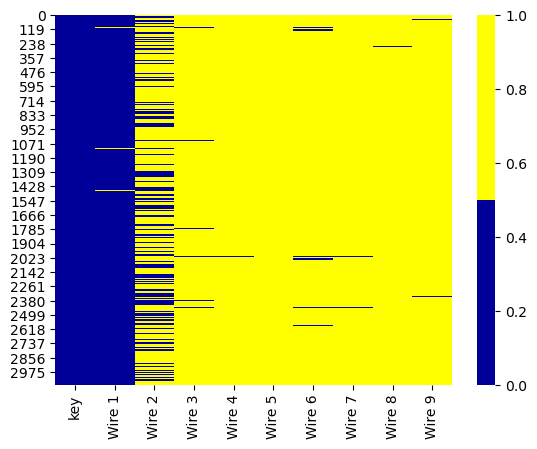

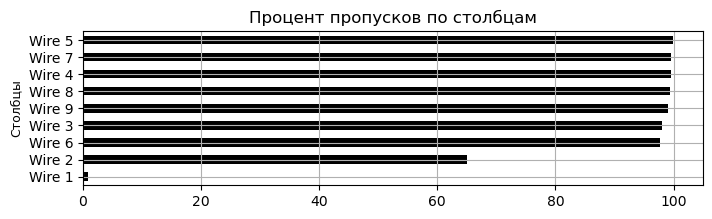

In [17]:
data_wire_time = load_csv('data_wire_time_new.csv', 
                         "https://code.s3.yandex.net/datasets/data_wire_time_new.csv")
information(data_wire_time,
            "таблицы об времени ввеения проволочых материалов 'data_wire_time_new.csv'")

In [18]:
for i in data_wire_time.columns:
    if i != 'key':
        data_wire_time[i] = pd.to_datetime(data_wire_time[i], format='%Y-%m-%d %H:%M:%S')
        #print(i)

Были загружены 7 файлов, содержащих параметры обработки расплавов металлов, их очистки и легирования, перемешивания продувкой инертным газом с подогревом электротоком. Кроме численных значений содержатся данные о ремени ввода тех или иных реагентов и замеров температуры.

Для различных сталей применяют разные компоненты из их большого числа, поэтому в 4 таблицах ввода сыпучих ингридиентов и проволоки много пропусков, до 75%.

### 2. Исследовательский анализ и предобработка данных

2.1 Таблица с данными о параметрах нагрева металла электротоком data_arc.

In [19]:
data_arc.columns = [i.replace(' ', "_").lower() for i in data_arc.columns]

Рассмотрим минимальное значение реактивной мощности. Она очень большая по модулю.

In [20]:
data_arc.реактивная_мощность.min()

-715.479924

In [21]:
data_arc[data_arc['реактивная_мощность'] < 0]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [22]:
data_arc_c = data_arc.copy()

In [23]:
data_arc_c = data_arc_c[data_arc_c['реактивная_мощность'] >= 0]
print(data_arc_c['реактивная_мощность'].corr(data_arc_c['активная_мощность']))

0.9663734456187303


Без этого экстремального значения коэффициент корреляции практически равен единице. Определим реальное значение реактивной мощности через аппроксимацию параболой.

In [24]:
def mapping1(values_x, a, b, c): 
    return a * values_x**2 + b * values_x + c

In [25]:
args, covar = curve_fit(mapping1, data_arc_c['активная_мощность'],
                                        data_arc_c['реактивная_мощность']) 
print("Arguments: ", args) 
#print("Co-Variance: ", covar) 

Arguments:  [0.01493309 0.71502924 0.00567026]


In [26]:
hh = data_arc['активная_мощность'][data_arc['реактивная_мощность'] < 0]
hh 

9780    0.705344
Name: активная_мощность, dtype: float64

In [27]:
data_arc.loc[data_arc['реактивная_мощность'] < 0, ['реактивная_мощность']] = \
                                                       mapping1(hh, args[0], args[1], args[2])

In [28]:
data_arc.iloc[9780]

key                                    2116
начало_нагрева_дугой    2019-07-28 02:22:08
конец_нагрева_дугой     2019-07-28 02:23:57
активная_мощность                  0.705344
реактивная_мощность                0.517441
Name: 9780, dtype: object

Определим в секундах время нагрева расплава электротоком. После найдём мощность электротока и суммарные затраты электроэнергии.

In [29]:
data_arc['время_нагрева'] = data_arc.apply(lambda row: (row['конец_нагрева_дугой']
                             - row['начало_нагрева_дугой']).total_seconds(), axis=1)

data_arc['полная_мощность'] = (data_arc['активная_мощность']**2 
                                + data_arc['реактивная_мощность']**2)**0.5

data_arc['энергозатраты'] = data_arc['время_нагрева'] * data_arc['полная_мощность']

In [30]:


data_arc.head()

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252


In [31]:
describe_main(data_arc.drop(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой'], axis=1))

активная_мощность


,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,0.662752,0.487117,171.670946,0.823388,141.643887
std,0.258885,0.197606,98.186803,0.323459,103.197606
min,0.223120,0.153777,11.000000,0.275718,6.409531
25%,0.467115,0.337192,107.000000,0.578847,71.158372
50%,0.599587,0.441667,147.000000,0.746591,114.462623
75%,0.830070,0.608201,214.000000,1.030390,181.345716
max,1.463773,1.270284,907.000000,1.898158,1084.729420


----------------------------------------------------------------------

реактивная_мощность


,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,0.662752,0.487117,171.670946,0.823388,141.643887
std,0.258885,0.197606,98.186803,0.323459,103.197606
min,0.223120,0.153777,11.000000,0.275718,6.409531
25%,0.467115,0.337192,107.000000,0.578847,71.158372
50%,0.599587,0.441667,147.000000,0.746591,114.462623
75%,0.830070,0.608201,214.000000,1.030390,181.345716
max,1.463773,1.270284,907.000000,1.898158,1084.729420


----------------------------------------------------------------------

время_нагрева


,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,0.662752,0.487117,171.670946,0.823388,141.643887
std,0.258885,0.197606,98.186803,0.323459,103.197606
min,0.223120,0.153777,11.000000,0.275718,6.409531
25%,0.467115,0.337192,107.000000,0.578847,71.158372
50%,0.599587,0.441667,147.000000,0.746591,114.462623
75%,0.830070,0.608201,214.000000,1.030390,181.345716
max,1.463773,1.270284,907.000000,1.898158,1084.729420


----------------------------------------------------------------------

полная_мощность


,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,0.662752,0.487117,171.670946,0.823388,141.643887
std,0.258885,0.197606,98.186803,0.323459,103.197606
min,0.223120,0.153777,11.000000,0.275718,6.409531
25%,0.467115,0.337192,107.000000,0.578847,71.158372
50%,0.599587,0.441667,147.000000,0.746591,114.462623
75%,0.830070,0.608201,214.000000,1.030390,181.345716
max,1.463773,1.270284,907.000000,1.898158,1084.729420


----------------------------------------------------------------------

энергозатраты


,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
count,14876.000000,14876.000000,14876.000000,14876.000000,14876.000000
mean,0.662752,0.487117,171.670946,0.823388,141.643887
std,0.258885,0.197606,98.186803,0.323459,103.197606
min,0.223120,0.153777,11.000000,0.275718,6.409531
25%,0.467115,0.337192,107.000000,0.578847,71.158372
50%,0.599587,0.441667,147.000000,0.746591,114.462623
75%,0.830070,0.608201,214.000000,1.030390,181.345716
max,1.463773,1.270284,907.000000,1.898158,1084.729420


----------------------------------------------------------------------



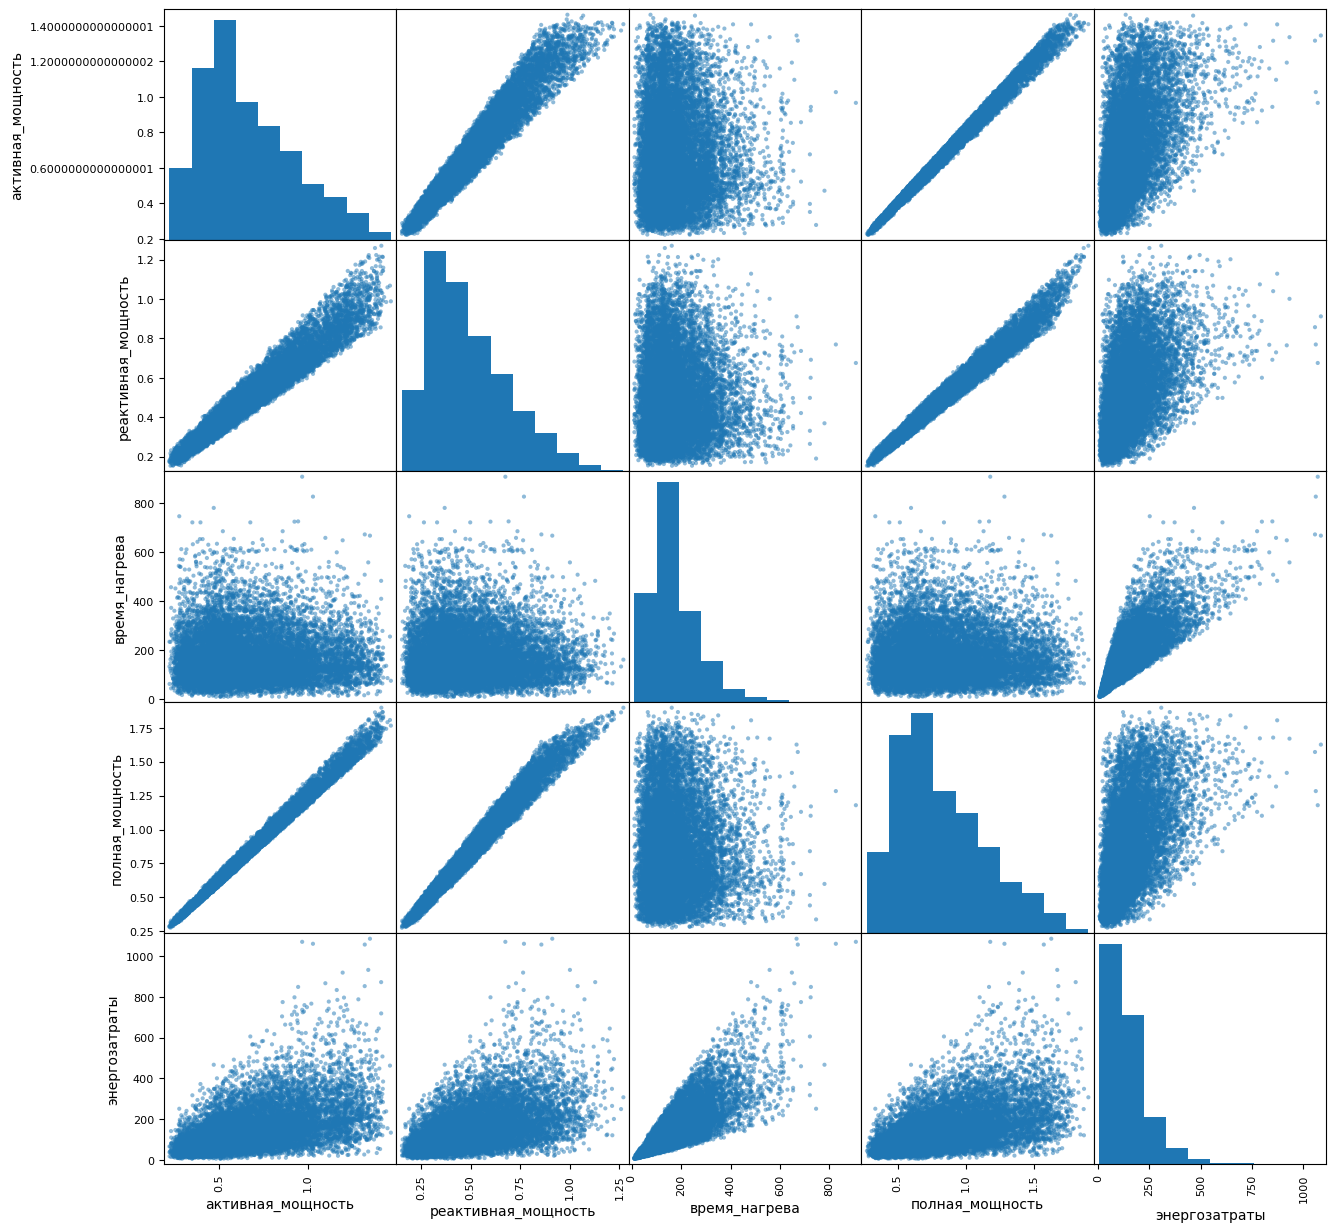

In [32]:
scatter_matrix(data_arc.drop('key', axis=1), figsize=(15, 15)) 
plt.show()

Видим чёткую линейную зависимость с высокой корреляцией между активной, реактивной и полной мощностями тока. Время нагрева пропорционально энергозатратам, но имеет ощутимую дисперсию.

Рассмотрим количество "итераций" (😂😂😂) над партиями металла.

In [33]:
data_arc.key.value_counts().sort_values(ascending=False)

key
2108    16
1689    15
1513    15
2567    14
46      13
        ..
246      1
49       1
556      1
1449     1
1615     1
Name: count, Length: 3214, dtype: int64

Строим гистограмму рапределения количества партий металла по числу технологических операций над одной партией.

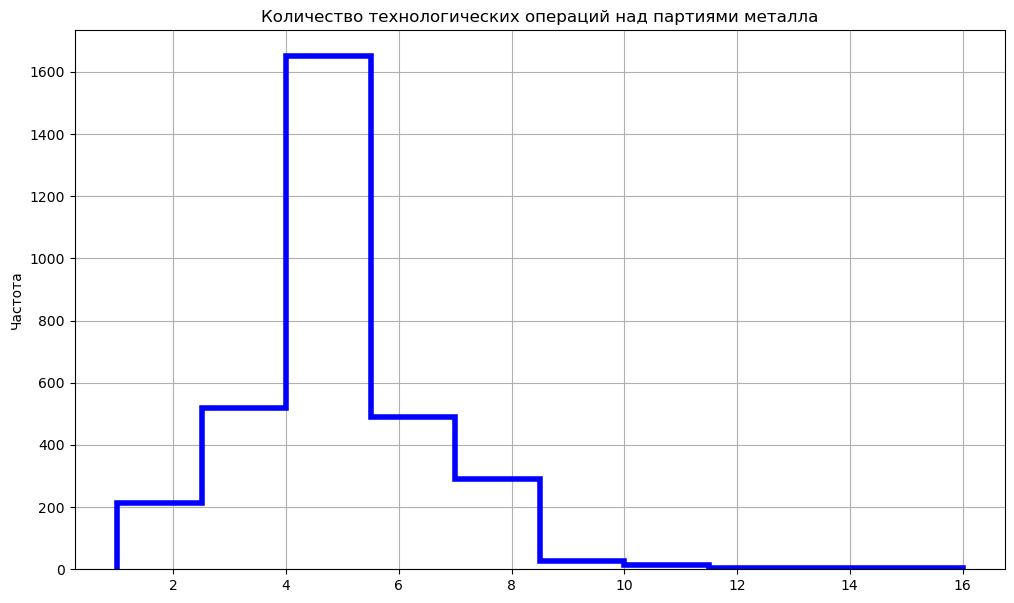

In [34]:
plt.title('Количество технологических операций над партиями металла')
ax=data_arc['key'].value_counts().plot(kind='hist', figsize=(12,7), grid=True, color='blue',
#                bins=40, , label='1 регион', legend=True,
              rwidth=0.01, alpha=1, histtype='step', linewidth=4)
plt.ylabel('Частота')
plt.show()

Наиболее часто встречающиеся значения операций 4 - 5.

Гистограмма аспределения активной, реактивной и полной мощностей эл.тока.

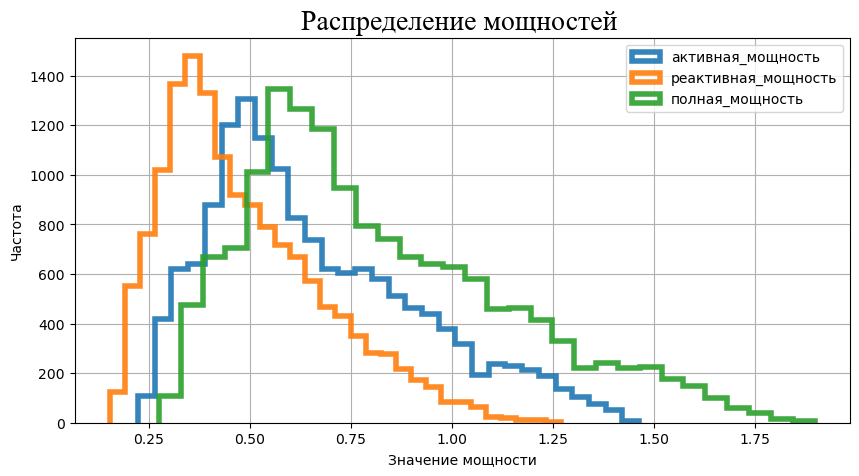

In [35]:
block_diagram(data_arc, 
              ['активная_мощность', 'реактивная_мощность', 'полная_мощность'], c = 30)

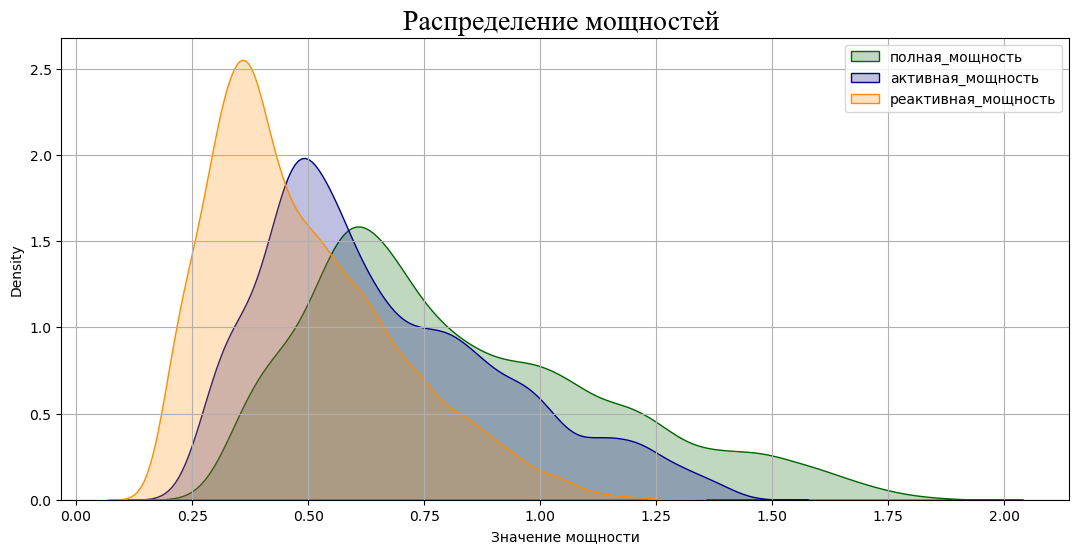

In [36]:
dens_diagram(data_arc, ['полная_мощность','активная_мощность', 'реактивная_мощность'])

РАспределения мощностей имеют схожую форму.

Диаграммы размахха признаков таблицы data_arc.

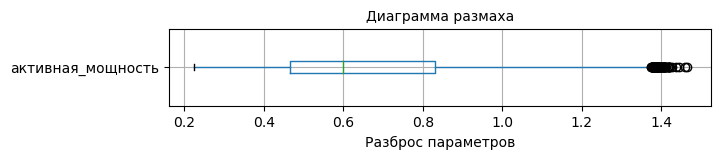

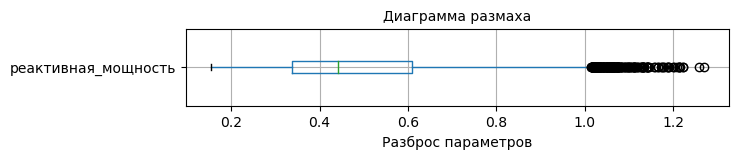

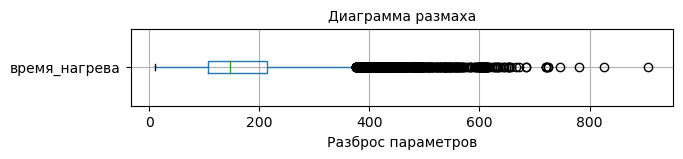

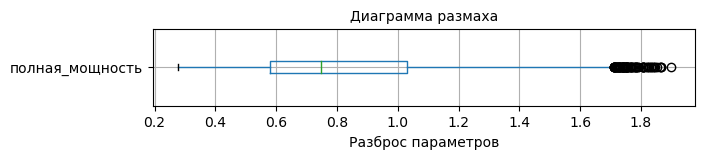

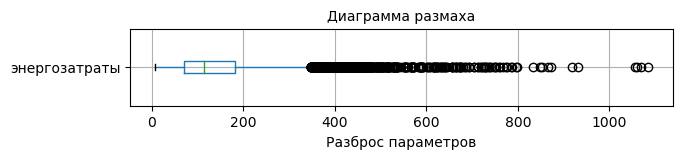

In [37]:
for j in data_arc.drop(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой'], axis=1).columns:
    data_arc.boxplot(column=j, figsize=(7,1), vert=False)
    plt.title('Диаграмма размаха', fontsize=10)
    plt.xlabel('Разброс параметров',color='black')
    plt.show()

На всех диаграммах размаха значительные выбросы в максимальной части.

Матрица корреляции признаков таблицы data_arc.

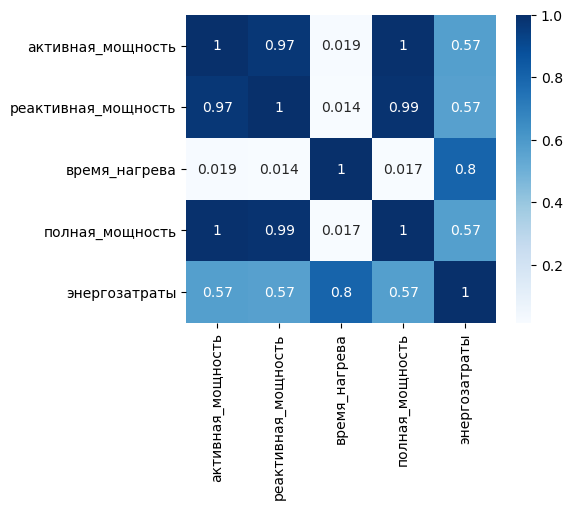

In [38]:
lst_col = data_arc.drop(['key', 'начало_нагрева_дугой', 'конец_нагрева_дугой'], axis=1
                       ).select_dtypes(exclude='object').columns.tolist()

plt.rcParams['figure.figsize'] = [5, 4]
sns.heatmap(data_arc[lst_col].corr(method='spearman'),
           cmap="Blues", annot=True)

plt.show()

Полная мощность высоко коррелирует с реактивной мощностью и активной мощностями.

Группируем данные таблицы  data_arc по партиям металла.

In [39]:
data_arc

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252
...,...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0,0.532085,83.537345
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0,0.792429,142.637202
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0,1.293389,237.983620
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0,0.641792,36.582120


In [40]:
af = {'конец_нагрева_дугой' : ['last'], 'время_нагрева': ['sum'], 'полная_мощность' :['sum'],
                                                        "энергозатраты" : [ 'count', 'sum']}

data_pivot = data_arc.pivot_table(index='key',
                                  #columns='энергозатраты',
                                  values=['конец_нагрева_дугой', 'время_нагрева',
                                          'полная_мощность', 'энергозатраты'],
                                  aggfunc=af)
data_pivot.columns = ['время_нагрева', 'конец_нагрева_дугой',  'полная_мощность',
                      'циклов_нагрева', 'энергозатраты']

In [41]:
data_pivot

,время_нагрева,конец_нагрева_дугой,полная_мощность,циклов_нагрева,энергозатраты
key,,,,,
1,1098.0,2019-05-03 11:28:37,3.718736,5,770.282114
2,811.0,2019-05-03 11:53:18,2.588349,4,481.760005
3,655.0,2019-05-03 12:32:19,5.019223,5,722.837668
4,741.0,2019-05-03 12:57:50,3.400038,4,683.455597
5,869.0,2019-05-03 13:33:55,2.816980,4,512.169934
...,...,...,...,...,...
3237,909.0,2019-09-06 11:53:55,3.250657,5,630.503534
3238,546.0,2019-09-06 12:31:35,1.723937,3,286.052252
3239,1216.0,2019-09-06 15:05:50,6.014480,8,941.538764


In [42]:
describe_main(data_pivot.drop('конец_нагрева_дугой', axis=1))

время_нагрева


,время_нагрева,полная_мощность,циклов_нагрева,энергозатраты
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,794.579029,3.811051,4.628500,655.598775
std,332.448622,1.502638,1.608647,308.944344
min,57.000000,0.331897,1.000000,33.430208
25%,571.000000,2.776480,4.000000,444.626580
50%,770.000000,3.694219,4.000000,620.101427
75%,983.000000,4.696915,6.000000,827.671845
max,4189.000000,15.288271,16.000000,4546.405812


----------------------------------------------------------------------

полная_мощность


,время_нагрева,полная_мощность,циклов_нагрева,энергозатраты
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,794.579029,3.811051,4.628500,655.598775
std,332.448622,1.502638,1.608647,308.944344
min,57.000000,0.331897,1.000000,33.430208
25%,571.000000,2.776480,4.000000,444.626580
50%,770.000000,3.694219,4.000000,620.101427
75%,983.000000,4.696915,6.000000,827.671845
max,4189.000000,15.288271,16.000000,4546.405812


----------------------------------------------------------------------

циклов_нагрева


,время_нагрева,полная_мощность,циклов_нагрева,энергозатраты
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,794.579029,3.811051,4.628500,655.598775
std,332.448622,1.502638,1.608647,308.944344
min,57.000000,0.331897,1.000000,33.430208
25%,571.000000,2.776480,4.000000,444.626580
50%,770.000000,3.694219,4.000000,620.101427
75%,983.000000,4.696915,6.000000,827.671845
max,4189.000000,15.288271,16.000000,4546.405812


----------------------------------------------------------------------

энергозатраты


,время_нагрева,полная_мощность,циклов_нагрева,энергозатраты
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,794.579029,3.811051,4.628500,655.598775
std,332.448622,1.502638,1.608647,308.944344
min,57.000000,0.331897,1.000000,33.430208
25%,571.000000,2.776480,4.000000,444.626580
50%,770.000000,3.694219,4.000000,620.101427
75%,983.000000,4.696915,6.000000,827.671845
max,4189.000000,15.288271,16.000000,4546.405812


----------------------------------------------------------------------



Матрица разброса свойдной таблицы data_pivot

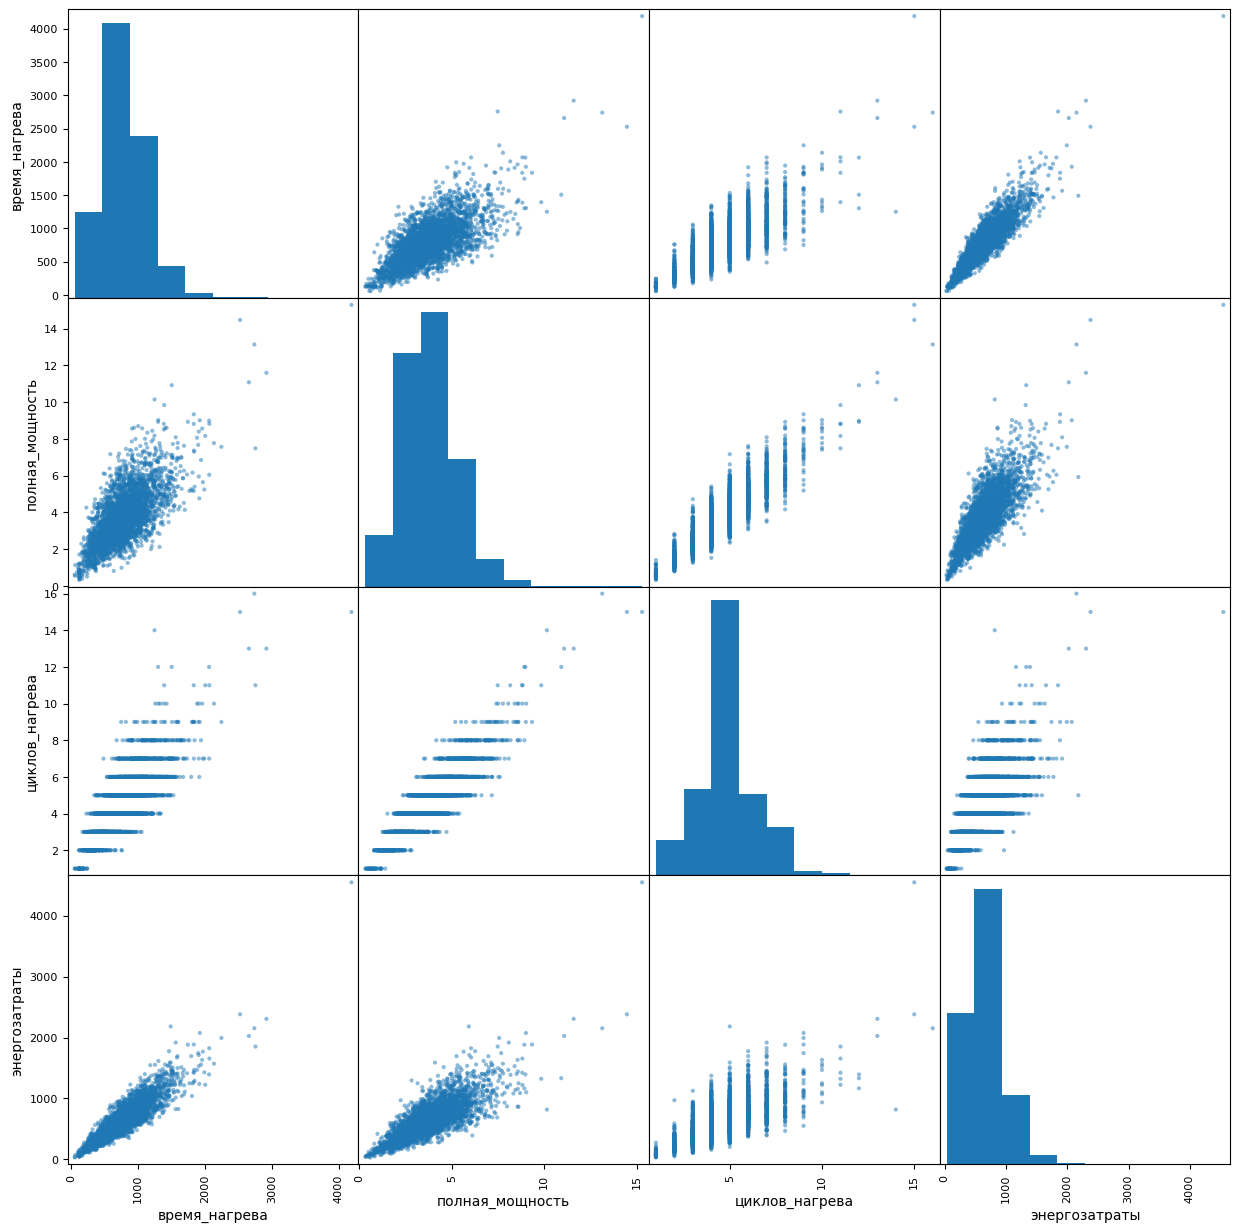

In [43]:
scatter_matrix(data_pivot, figsize=(15, 15)) 
plt.show()

В сводной таблице сохраняется корреляция между основными параметрами нагрева, но с увеличившейся дисперсией.

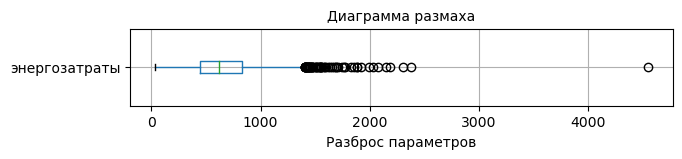

In [44]:
data_pivot.boxplot(column='энергозатраты', figsize=(7,1), vert=False)
plt.title('Диаграмма размаха', fontsize=10)
plt.xlabel('Разброс параметров',color='black')
plt.show()

In [45]:
data_pivot[data_pivot['энергозатраты']>3000]

,время_нагрева,конец_нагрева_дугой,полная_мощность,циклов_нагрева,энергозатраты
key,,,,,
1689,4189.0,2019-07-05 14:38:46,15.288271,15,4546.405812


In [46]:
data_pivot = data_pivot[data_pivot['энергозатраты']<3000]

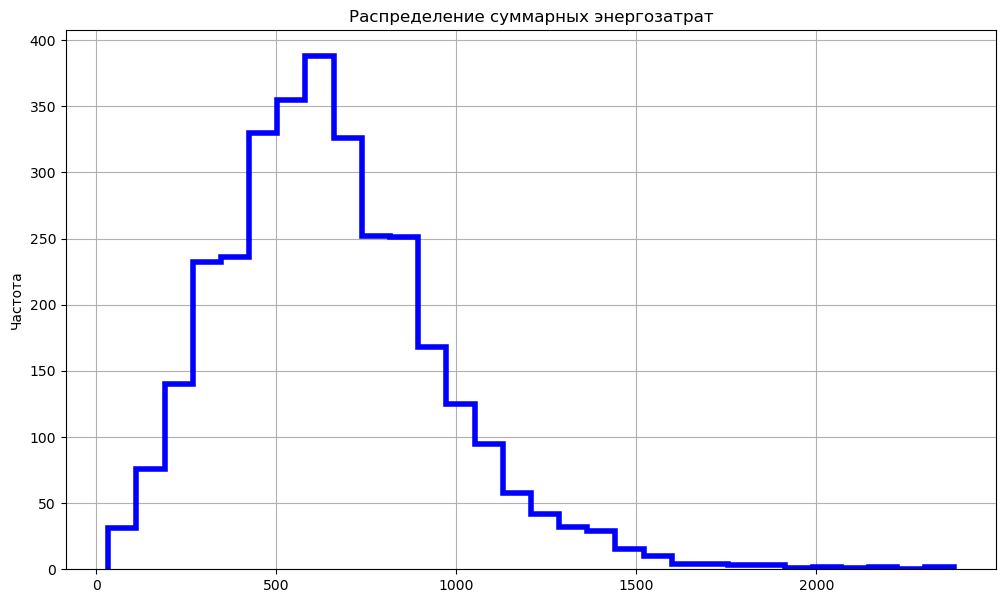

In [47]:
plt.title('Распределение суммарных энергозатрат')
ax=data_pivot['энергозатраты'].plot(kind='hist', figsize=(12,7), grid=True, color='blue', bins=30,
               #                                    , label='1 регион', legend=True,
              rwidth=0.01, alpha=1, histtype='step', linewidth=4)
plt.ylabel('Частота')
plt.show()

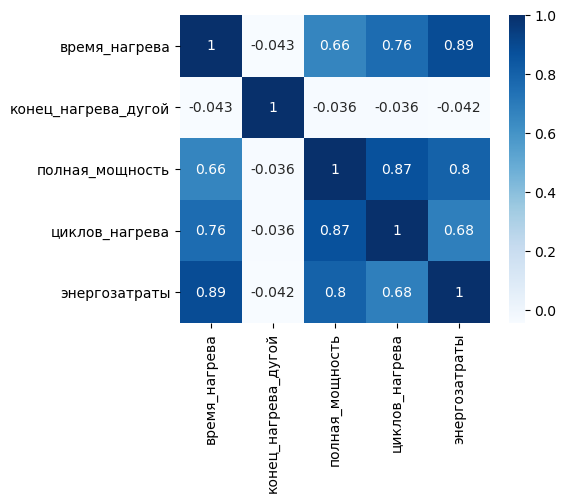

In [48]:
lst_col = data_pivot.select_dtypes(exclude='object').columns.tolist()

plt.rcParams['figure.figsize'] = [5, 4]
sns.heatmap(data_pivot[lst_col].corr(method='spearman'),
           cmap="Blues", annot=True)

plt.show()

Высокие корреляции между энергозатратами и временем нагрева, а также полной мощностью и циклами нагрева.
.


2.2 Рассмотрим таблицу data_bulk

In [49]:
data_bulk.columns = [i.replace(' ', "").lower() for i in data_bulk.columns]
data_bulk.fillna(0, inplace=True)
print(data_bulk.isna().sum().sum())
data_bulk.head()

0


,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


В таблице много  пропусков, это свидетельствует о том, что не все используемые реагенты применяются в каждой партии металла, так как необходимы изделия с разными физическими свойствами. Поэтому пропуски заменяем на нули.



In [50]:
describe_main(data_bulk.drop('key', axis=1))

bulk1


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk2


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk3


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk4


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk5


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk6


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk7


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk8


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk9


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk10


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk11


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk12


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk13


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk14


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------

bulk15


,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


----------------------------------------------------------------------



2.3 Таблица data_bulk_time

In [51]:
data_bulk_time.columns = [i.replace(' ', "").lower() for i in data_bulk_time.columns]
data_bulk_time

,key,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,bulk11,bulk12,bulk13,bulk14,bulk15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34


2.4 Таблица продувки инертным газом.

In [52]:
data_gas.columns = [i.replace(' ', "").lower() for i in data_gas.columns]
data_gas.head()

,key,газ1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [53]:
describe_main(data_gas.drop('key', axis=1))

газ1


,газ1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


----------------------------------------------------------------------



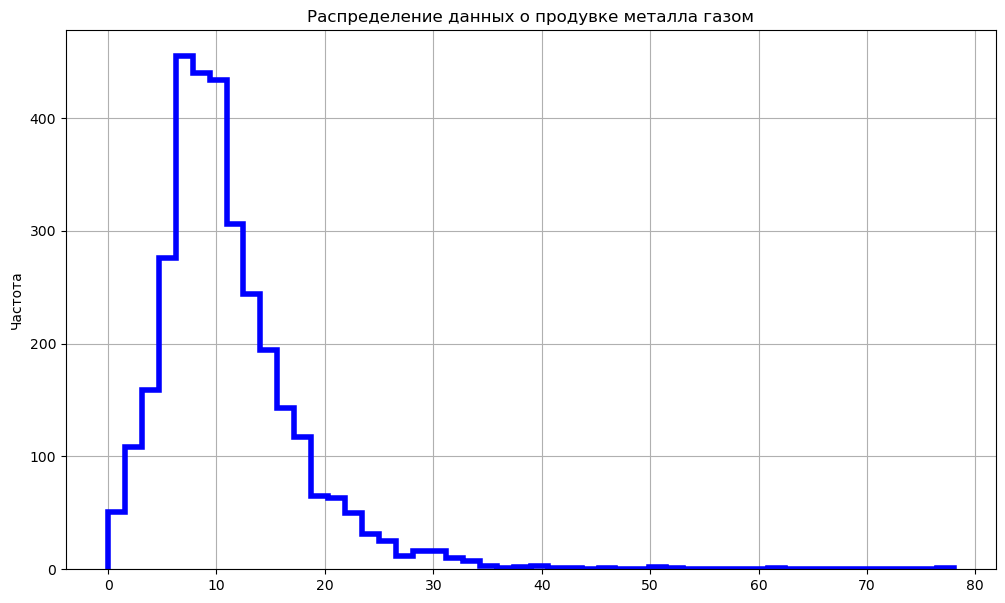

In [54]:
plt.title('Распределение данных о продувке металла газом')
ax=data_gas['газ1'].plot(kind='hist', figsize=(12,7), grid=True, color='blue', bins=50,
               #                                    , label='1 регион', legend=True,
              rwidth=0.01, alpha=1, histtype='step', linewidth=4)
plt.ylabel('Частота')
plt.show()

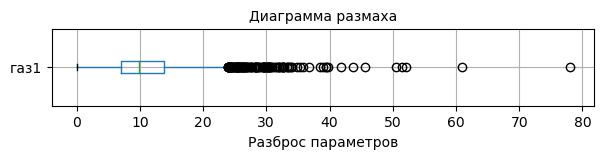

In [55]:
data_gas.boxplot(column='газ1', figsize=(7,1), vert=False)
plt.title('Диаграмма размаха', fontsize=10)
plt.xlabel('Разброс параметров',color='black')
plt.show()

В значениях продувки газом также выбросы в максимальной части. Стараются лучше размешать.

2.5 Таблица времени замера и температуры расплава металла.

In [56]:
data_temp.columns = [i.replace(' ', "_").lower() for i in data_temp.columns]
data_temp = data_temp.dropna()
data_temp.shape

(14665, 3)

In [57]:
data_temp.isna().sum()

key             0
время_замера    0
температура     0
dtype: int64

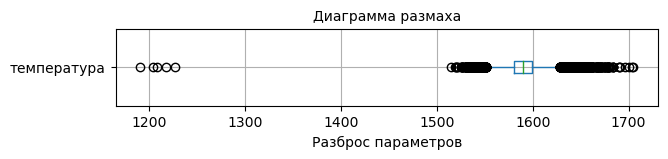

In [58]:
data_temp.boxplot(column='температура', figsize=(7,1), vert=False)
plt.title('Диаграмма размаха', fontsize=10)
plt.xlabel('Разброс параметров',color='black')
plt.show()

Видим несколько выбросов нетипично низкой температуры ок 1200 гр.

In [59]:
data_temp[data_temp['температура'] <1400]


,key,время_замера,температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [60]:
data_temp[data_temp['key'] == 867]

,key,время_замера,температура
4883,867,2019-06-06 08:03:39,1191.0
4884,867,2019-06-06 08:18:52,1575.0
4885,867,2019-06-06 08:22:38,1576.0
4886,867,2019-06-06 08:25:11,1571.0
4887,867,2019-06-06 08:29:49,1600.0
4888,867,2019-06-06 08:36:49,1522.0
4889,867,2019-06-06 08:43:02,1521.0
4890,867,2019-06-06 08:48:23,1599.0


In [61]:
data_arc[data_arc['key'] == 867]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,время_нагрева,полная_мощность,энергозатраты
4028,867,2019-06-06 08:03:49,2019-06-06 08:06:04,1.362161,0.948663,135.0,1.659953,224.093660
4029,867,2019-06-06 08:19:02,2019-06-06 08:21:37,0.520198,0.391826,155.0,0.651255,100.944584
4030,867,2019-06-06 08:22:48,2019-06-06 08:23:47,0.558775,0.361147,59.0,0.665324,39.254144
4031,867,2019-06-06 08:25:21,2019-06-06 08:27:11,0.525132,0.411021,110.0,0.666860,73.354569
4032,867,2019-06-06 08:29:59,2019-06-06 08:33:08,0.661064,0.578344,189.0,0.878344,166.006931
4033,867,2019-06-06 08:36:59,2019-06-06 08:41:13,0.365236,0.292677,254.0,0.468035,118.880999
4034,867,2019-06-06 08:43:12,2019-06-06 08:44:19,0.852855,0.620585,67.0,1.054745,70.667927


Считаем данные по температуре, меньше чем 1400 гр выбросами и удаляем все данные с такими номерами парти металла. 

In [62]:
lst_dlt = data_temp[data_temp['температура'] < 1400]['key'].to_list()
lst_dlt

[867, 1214, 1619, 2052, 2561]

In [63]:
data_temp = data_temp.query("key != @lst_dlt")
data_temp.shape

(14643, 3)

Проверяем.

In [64]:
(data_temp['температура'] < 1400).sum()

0

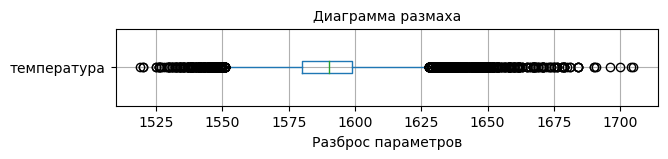

In [65]:
data_temp.boxplot(column='температура', figsize=(7,1), vert=False)
plt.title('Диаграмма размаха', fontsize=10)
plt.xlabel('Разброс параметров',color='black')
plt.show()

Здесь выбросы и справа и слева.

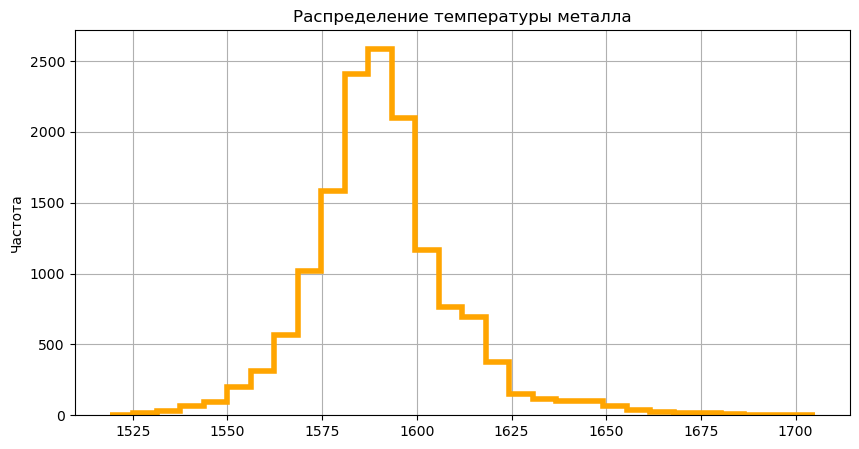

In [66]:
plt.title('Распределение температуры металла')
ax=data_temp['температура'].plot(kind='hist', figsize=(10,5), grid=True, color='orange', bins=30,
               #                                    , label='1 регион', legend=True,
              rwidth=0.01, alpha=1, histtype='step', linewidth=4)
plt.ylabel('Частота')
plt.show()

Средняя температура замера расплава металла 1550 - 1625 гр.

In [67]:
describe_main(data_temp.drop('key', axis=1))

время_замера


,время_замера,температура
count,14643,14643.000000
mean,2019-06-23 23:49:11.933005568,1590.865055
min,2019-05-03 11:02:04,1519.000000
25%,2019-05-28 23:23:45,1580.000000
50%,2019-06-21 23:01:54,1590.000000
75%,2019-07-21 22:29:47.500000,1599.000000
max,2019-09-06 16:48:55,1705.000000
std,NaN,19.122102


----------------------------------------------------------------------

температура


,время_замера,температура
count,14643,14643.000000
mean,2019-06-23 23:49:11.933005568,1590.865055
min,2019-05-03 11:02:04,1519.000000
25%,2019-05-28 23:23:45,1580.000000
50%,2019-06-21 23:01:54,1590.000000
75%,2019-07-21 22:29:47.500000,1599.000000
max,2019-09-06 16:48:55,1705.000000
std,NaN,19.122102


----------------------------------------------------------------------



2.6 Таблица вводимой проволоки.

In [68]:
data_wire.columns = [i.replace(' ', "").lower() for i in data_wire.columns]
data_wire.fillna(0, inplace=True)
print(data_wire.isna().sum().sum())
data_wire.head()

0


,key,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Группируем данные по партиям металла

In [69]:
data_pivot_temp = data_temp.pivot_table(index='key',
                                  #columns='энергозатраты',
                                  values=["время_замера", 'температура'],
                                  aggfunc=['first', 'last'])
data_pivot_temp.columns = ['first_measuring',  'first_temp', 'last_measuring', 'last_temp']

In [70]:
data_pivot_temp.shape

(3211, 4)

In [71]:
data_pivot_temp[data_pivot_temp['first_measuring'] == data_pivot_temp['last_measuring']]

,first_measuring,first_temp,last_measuring,last_temp
key,,,,
195,2019-05-11 00:01:36,1583.0,2019-05-11 00:01:36,1583.0
279,2019-05-14 10:13:01,1603.0,2019-05-14 10:13:01,1603.0
2500,2019-08-10 14:04:39,1539.0,2019-08-10 14:04:39,1539.0
2501,2019-08-10 14:41:14,1587.0,2019-08-10 14:41:14,1587.0
2502,2019-08-10 15:39:39,1583.0,2019-08-10 15:39:39,1583.0
...,...,...,...,...
3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0
3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0
3239,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0


740 строк данных единственного замера температуры расплавленного металла во время всего технологического процесса.

In [72]:
data_pivot_temp = data_pivot_temp[data_pivot_temp['first_measuring'] != \
                                                             data_pivot_temp['last_measuring']]

In [73]:
data_pivot_temp.shape

(2471, 4)

Объединяем данные со временем .

In [74]:
merged_time = data_bulk_time.merge(data_pivot['конец_нагрева_дугой'], on="key")

In [75]:
merged_time1 = merged_time.merge(data_wire_time, on="key")

In [76]:
merged_time2 = merged_time1.merge(data_pivot_temp[['first_measuring', 'last_measuring']],
                                                                               on="key")
merged_time2 = merged_time2.set_index('key')

In [77]:
merged_time2.head()

,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,...,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,first_measuring,last_measuring
key,,,,,,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:02:04,2019-05-03 11:30:38
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:34:04,2019-05-03 11:55:09
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:06:44,2019-05-03 12:35:57
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:39:27,2019-05-03 12:59:47
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:11:03,2019-05-03 13:36:39


In [78]:
merged_time2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2326 entries, 1 to 2499
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   bulk1                199 non-null    datetime64[ns]
 1   bulk2                13 non-null     datetime64[ns]
 2   bulk3                958 non-null    datetime64[ns]
 3   bulk4                812 non-null    datetime64[ns]
 4   bulk5                53 non-null     datetime64[ns]
 5   bulk6                438 non-null    datetime64[ns]
 6   bulk7                13 non-null     datetime64[ns]
 7   bulk8                1 non-null      datetime64[ns]
 8   bulk9                13 non-null     datetime64[ns]
 9   bulk10               143 non-null    datetime64[ns]
 10  bulk11               130 non-null    datetime64[ns]
 11  bulk12               1810 non-null   datetime64[ns]
 12  bulk13               13 non-null     datetime64[ns]
 13  bulk14               2066 non-null   d

Находим максимальное и минимальное времена события, определеяем, какое время события не соответствует начальному и конечному замерам температуры. Эти данные удаляем.

In [79]:
merged_time2['max'] = merged_time2.max(axis=1)

In [80]:
merged_time2.head()

,bulk1,bulk2,bulk3,bulk4,bulk5,bulk6,bulk7,bulk8,bulk9,bulk10,...,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,first_measuring,last_measuring,max
key,,,,,,,,,,,,,,,,,,,,,
1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:02:04,2019-05-03 11:30:38,2019-05-03 11:30:38
2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:34:04,2019-05-03 11:55:09,2019-05-03 11:55:09
3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:06:44,2019-05-03 12:35:57,2019-05-03 12:35:57
4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:39:27,2019-05-03 12:59:47,2019-05-03 12:59:47
5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:11:03,2019-05-03 13:36:39,2019-05-03 13:36:39


In [81]:
merged_time2.shape

(2326, 28)

In [82]:
merged_time2[merged_time2['last_measuring'] == merged_time2['max']].shape

(2326, 28)

In [83]:
merged_time2['min'] = merged_time2.min(axis=1)

In [84]:
merged_time2[merged_time2['first_measuring'] == merged_time2['min']].shape

(2326, 29)

## 3. Объединение данных

Удаляем 'конец_нагрева_дугой', деллаем номер партии индексом, объединяем таблицы data_pivot, data_bulk, data_wire и data_gas по индексам партий.

In [85]:
data_pivot = data_pivot.drop('конец_нагрева_дугой', axis=1)


In [86]:
data_bulk = data_bulk.set_index('key')
data_wire = data_wire.set_index('key')
data_gas = data_gas.set_index('key')

In [87]:
data_main = data_bulk.merge(data_pivot, on="key")
data_pivot.shape, data_bulk.shape, data_main.shape

((3213, 4), (3129, 15), (3127, 19))

In [88]:
data_main = data_wire.merge(data_main, on="key")
data_wire.shape, data_main.shape

((3081, 9), (3023, 28))

In [89]:
data_main = data_gas.merge(data_main, on="key")
data_gas.shape, data_main.shape

((3239, 1), (3021, 29))

In [90]:
data_main = data_main.merge(data_pivot_temp[['first_temp', 'last_temp']], on="key")
data_main.shape

(2324, 31)

In [91]:
data_main.head()

,газ1,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,...,bulk12,bulk13,bulk14,bulk15,время_нагрева,полная_мощность,циклов_нагрева,энергозатраты,first_temp,last_temp
key,,,,,,,,,,,,,,,,,,,,,
1,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,150.0,154.0,1098.0,3.718736,5,770.282114,1571.0,1613.0
2,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,149.0,154.0,811.0,2.588349,4,481.760005,1581.0,1602.0
3,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,205.0,0.0,152.0,153.0,655.0,5.019223,5,722.837668,1596.0,1599.0
4,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,207.0,0.0,153.0,154.0,741.0,3.400038,4,683.455597,1601.0,1625.0
5,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,0.0,151.0,152.0,869.0,2.816980,4,512.169934,1576.0,1602.0


In [92]:
data_main

,газ1,wire1,wire2,wire3,wire4,wire5,wire6,wire7,wire8,wire9,...,bulk12,bulk13,bulk14,bulk15,время_нагрева,полная_мощность,циклов_нагрева,энергозатраты,first_temp,last_temp
key,,,,,,,,,,,,,,,,,,,,,
1,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,150.0,154.0,1098.0,3.718736,5,770.282114,1571.0,1613.0
2,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,149.0,154.0,811.0,2.588349,4,481.760005,1581.0,1602.0
3,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,205.0,0.0,152.0,153.0,655.0,5.019223,5,722.837668,1596.0,1599.0
4,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,207.0,0.0,153.0,154.0,741.0,3.400038,4,683.455597,1601.0,1625.0
5,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,0.0,151.0,152.0,869.0,2.816980,4,512.169934,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256.0,0.0,129.0,223.0,723.0,3.868721,4,694.177326,1570.0,1591.0
2496,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256.0,0.0,129.0,226.0,940.0,5.070316,6,815.818538,1554.0,1591.0
2497,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,230.0,0.0,124.0,226.0,569.0,4.360918,3,823.020520,1571.0,1589.0


Корреляция с целевым признаком.

In [93]:
corr_target = pd.Series()
for col in data_main.columns:
    corr_target[col] = data_main['last_temp'].corr(data_main[col])
corr_target= corr_target.sort_values(ascending=False)[1:]

C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Lenovo\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


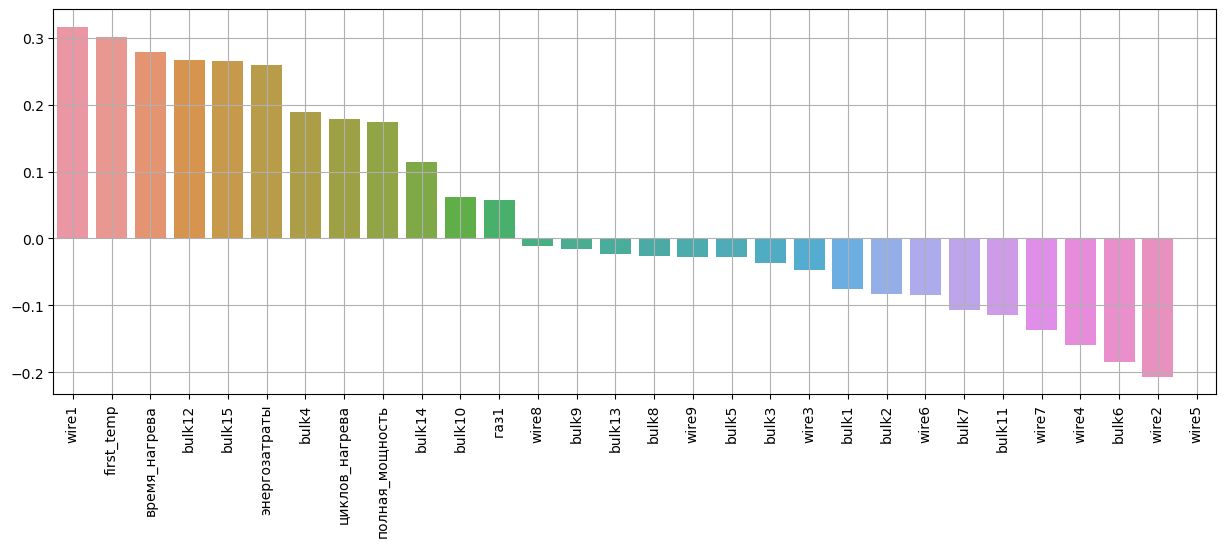

In [94]:
plt.figure(figsize=(15,5))
sns.barplot(x=corr_target.index, y=corr_target.values)
plt.grid()
plt.xticks(rotation=90)
plt.show();

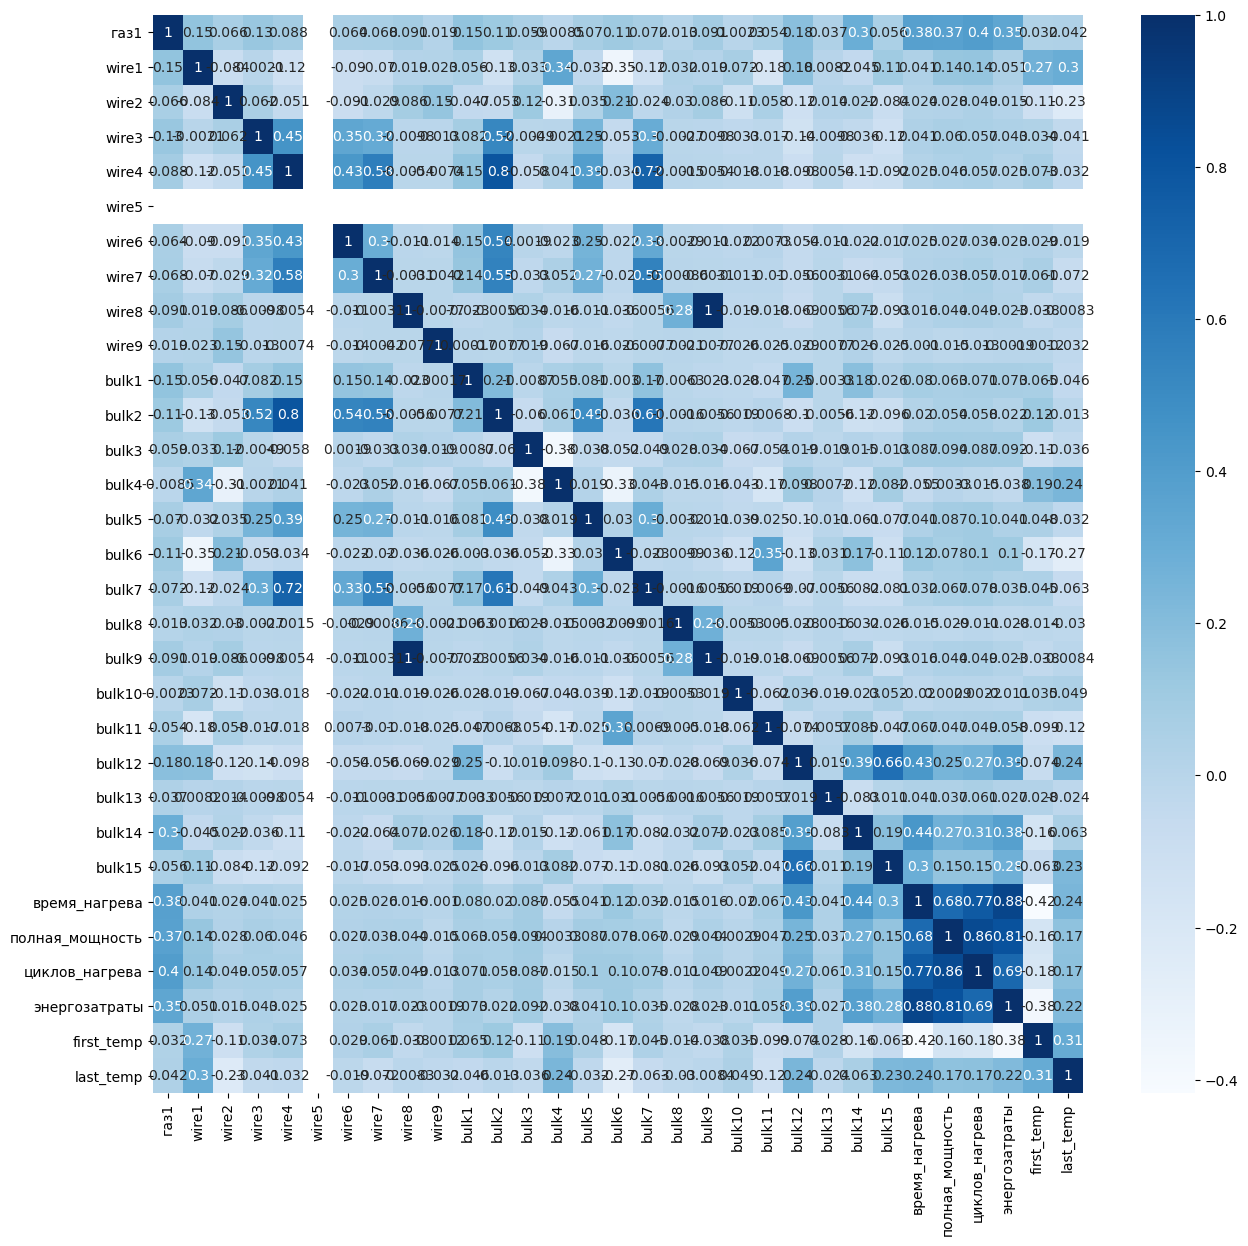

In [95]:
lst_col = data_main.select_dtypes(exclude='object').columns.tolist()

plt.rcParams['figure.figsize'] = [15, 14]
sns.heatmap(data_main[lst_col].corr(method='spearman'),
           cmap="Blues", annot=True)

plt.show()

Из  матрицы видно, что 'wire8' зквивалентен "bulk9". Значений 'wire5' нет.

In [96]:
data_main = data_main.drop(['wire5', 'wire8'], axis=1)

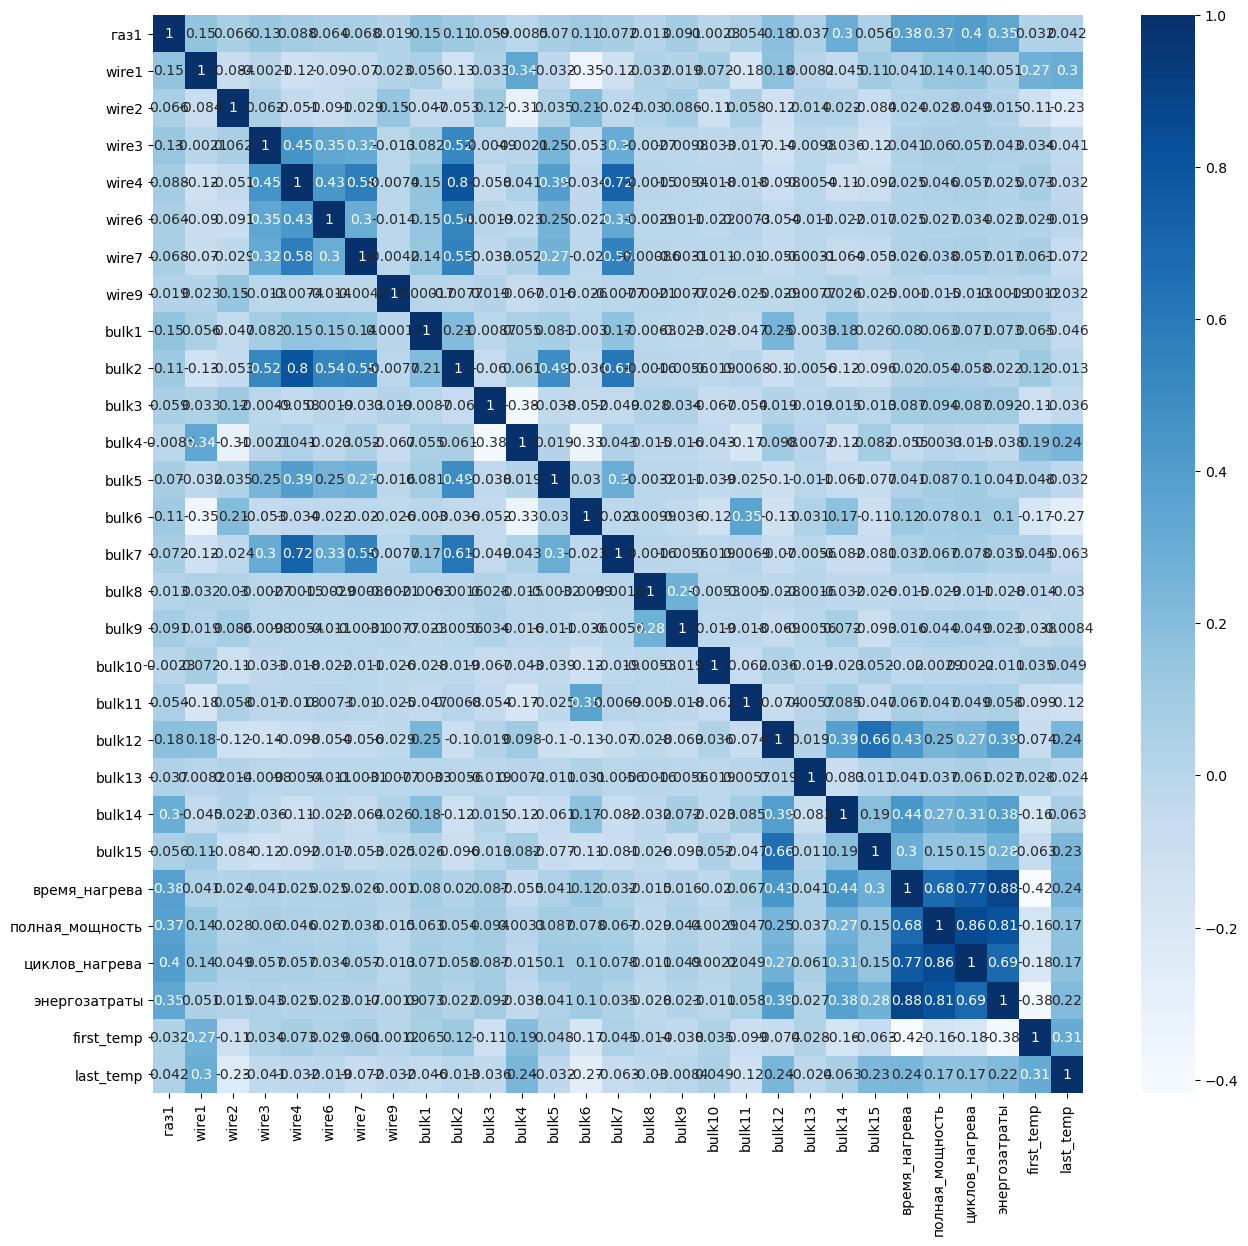

In [97]:
lst_col = data_main.select_dtypes(exclude='object').columns.tolist()

plt.rcParams['figure.figsize'] = [15, 14]
sns.heatmap(data_main[lst_col].corr(method='spearman'),
           cmap="Blues", annot=True)

plt.show()

Энергозатраты и время нагрева высоко коррелируют между собой. Замена этих значений на среднее геометрическое не увеличивает качество предсказания.


data_main['эн_вр'] = (data_main['энергозатраты']*data_main['время_нагрева'])**0.5

data_main = data_main.drop(['энергозатраты', 'время_нагрева'], axis=1)

## 4-5. Подготовка данных и обучение модели.

In [98]:
from scipy import stats as st
# Визуализация объяснимости моделей
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor #KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor #DecisionTreeClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor #, RandomForestClassifier
#from sklearn.model_selection import (StratifiedKFold, KFold)
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  train_test_split, GridSearchCV #, RandomizedSearch, CVGridSearchCV
from sklearn.linear_model import Ridge, Lasso

from sklearn.metrics import (r2_score, roc_auc_score, f1_score, fbeta_score, accuracy_score,
                             recall_score, make_scorer, precision_score, mean_absolute_error,
                            mean_squared_error, root_mean_squared_error)

from sklearn.preprocessing import (
#    OneHotEncoder,
#    LabelEncoder,
#    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

In [99]:
X = data_main.drop(columns=['last_temp'])
y = data_main['last_temp']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=TEST_SIZE,
                                    random_state=RANDOM_STATE)

In [100]:
print(len(y_train), len(y_test), round(len(y_test)/len(y_train)*0.75, 5))

1743 581 0.25


In [101]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), X.columns)], remainder='passthrough')

data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 Index(['газ1', 'wire1', 'wire2', 'wire3', 'wire4', 'wire6', 'wire7', 'wire9',
       'bulk1', 'bulk2', 'bulk3', 'bulk4', 'bulk5', 'bulk6', 'bulk7', 'bulk8',
       'bulk9', 'bulk10', 'bulk11', 'bulk12', 'bulk13', 'bulk14', 'bulk15',
       'время_нагрева', 'полная_мощность', 'циклов_нагрева', 'энергозатраты',
       'first_temp'],
      dtype='object'))])

In [ ]:
%%time

pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

param_distributions = [

    {
    'models': [Ridge()],
        # указываем гиперпараметр модели n_neighbors
    'models__alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
        # указываем список методов масштабирования
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },   
    
    {# название модели
    'models': [Lasso()],
        # указываем гиперпараметр модели n_neighbors
    'models__alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100],
        # указываем список методов масштабирования
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },   
    
    {       
        # название модели
    'models': [KNeighborsRegressor()],
        # указываем гиперпараметр модели n_neighbors
    'models__n_neighbors': range(3, 60, 3),
    'models__metric' : ['euclidean', 'manhattan'], 
        # указываем список методов масштабирования
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
       
    {
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(2, 11, 2),
    'models__min_samples_split': [2, 5, 10],
    'models__min_samples_leaf': [1, 2, 4, 8],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
    'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': [80, 90, 100, None],
    'models__max_features': ["sqrt", "log2", None],
    'models__min_samples_leaf': [1, 3, 5],
    'models__min_samples_split': [2, 3, 4],
    'models__n_estimators': [10, 25, 50, 75, 100],  
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
   },    
          
    {
    'models': [LGBMRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(5, 32, 5),
    'models__n_estimators': [30, 60, 100],
    'models__learning_rate': [0.1, 0.2, 0.3],
    'models__min_samples_leaf': [1, 2, 4],   
    'models__eta': [0.3],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(),  RobustScaler(), 'passthrough']}                    
]

grid_search = GridSearchCV(
    pipe_final, 
    param_grid=param_distributions,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print('Метрика МАЕ для лучшей модели:\n', grid_search.best_score_)
print('\nЛучшая модель и её параметры:\n', grid_search.best_params_)

#print('\nНазвания:\n', 
#      grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

Fitting 5 folds for each of 2728 candidates, totalling 13640 fits


Лучшая модель и её параметры:

 
 {'models': LGBMRegressor(random_state=29102024), 'models__eta': 0.3, 'models__learning_rate': 0.1, 'models__max_depth': 20, 'models__min_samples_leaf': 2, 'models__n_estimators': 60, 'preprocessor__num': StandardScaler()}
 
 Метрика МАЕ для лучшей модели:
 -6.177121400817982
 
 CPU times: total: 2min 52s
Wall time: 9h 26min 7s

In [106]:
#from scipy import stats as st
#import shap
#from sklearn.metrics import (r2_score, roc_auc_score, f1_score, fbeta_score, accuracy_score,
# recall_score, make_scorer, precision_score, mean_absolute_error,
                            #mean_squared_error, root_mean_squared_error)

def final_calcul(grd_srch):
    best_params = grd_srch.best_params_
    best_score = grd_srch.best_score_

    print("Лучшая модель и её параметры  ", best_params, best_score)
    print("*"*80)
# обучите модель на тренировочных данных
#grid_search.fit(X_train, y_train)

# получите предсказания модели на тестовых данных 
# сохраните результат в переменную predictions
    predictions = grd_srch.predict(X_test)

    print("Первые четыре значения предсказания целевого признака \
    и его значение из тестовой выборки")
    print(predictions[0], "  ", y_test.reset_index(drop = True)[0])
    print(predictions[1], "  ", y_test.reset_index(drop = True)[1])
    print(predictions[2], "  ", y_test.reset_index(drop = True)[2])
    print(predictions[3], "  ", y_test.reset_index(drop = True)[3])
    print("*"*70)

    r2 =  r2_score(y_test, predictions)  

# выведите полученное значение R2
    print(f"R2 лучшей модели {grd_srch.best_estimator_.named_steps['models']} = {r2:.6f}")

    mae = mean_absolute_error(y_test, predictions)
    print(f'MAE = {mae:.2f}')

    mse = mean_squared_error(y_test, predictions) 
    print(f'MSE = {mse:.2f}')

    rmse = root_mean_squared_error( y_test, predictions)
    print(f'RMSE = {rmse:.2f}')
    print("*"*70)

    print(f"Среднее предсказанное значение - {predictions.mean():.4f}")
    print("*"*70)   

    predictions2 = pd.Series(predictions, index=y_test.index)
    test_y2 = y_test

    zapas_sr2 = predictions.mean()
    sigma2 = rmse
#*******************************************************   
    residuals = y_test - predictions
    print(f"Интервал остатков от {residuals.min():.4f} до {residuals.max():.4f}")
    
    conf_int = st.t.interval(
    0.95, len(residuals)-1, residuals.mean(), scale=st.sem(residuals))

    print(f"Доверительный интервал '0.95' от {conf_int[0]:.4f} до {conf_int[1]:.4f}")   
    print("*"*100)    
    print()

    
    print("                                         АНАЛИЗ  ОСТАТКОВ")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
    axes[0].hist(residuals, color = "purple")
    axes[0].grid(True)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x=predictions, y=residuals, s= 5, color = "red")
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.grid(True)
    plt.show()
    print("*"*100)
    print("                                         АНАЛИЗ  ВАЖНОСТИ ПРИЗНАКОВ")
    X_encoded_1 = grd_srch.best_estimator_['preprocessor'].fit_transform(X_train)

    model_1 = grd_srch.best_estimator_['models'].fit(X_encoded_1, y_train)
    explainer_1 = shap.PermutationExplainer(model_1, X_encoded_1)

    labels_1 = grd_srch.best_estimator_[:-1].get_feature_names_out()
    plt.grid(True)

    shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=labels_1, color = "green",
                     plot_size=(8,4.5))


Лучшая модель и её параметры   {'models': LGBMRegressor(random_state=29102024), 'models__eta': 0.3, 'models__learning_rate': 0.1, 'models__max_depth': 20, 'models__min_samples_leaf': 2, 'models__n_estimators': 60, 'preprocessor__num': StandardScaler()} -6.177121400817982
********************************************************************************
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
Первые четыре значения предсказания целевого признака     и его значение из тестовой выборки
1592.1576764774804    1591.0
1602.2622859066093    1614.0
1608.2487922059738    1594.0
1593.1319638864686    1586.0
**********************************************************************
R2 лучшей модели LGBMRegressor(eta=0.3, max_depth=20, min_samples_leaf=2, n_estimators=60,
              random_st

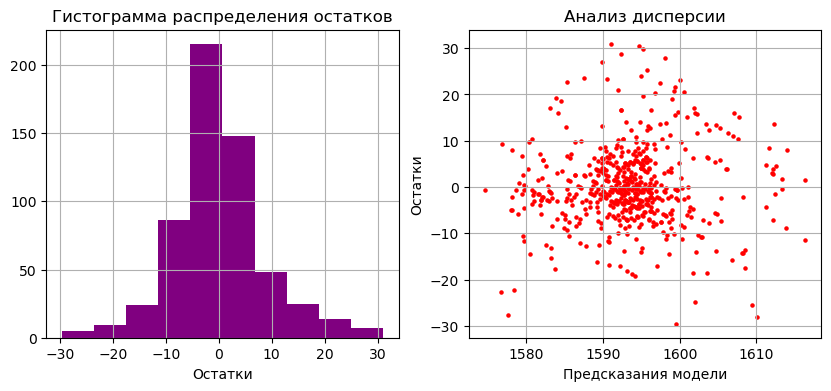

****************************************************************************************************
                                         АНАЛИЗ  ВАЖНОСТИ ПРИЗНАКОВ
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 1743, n

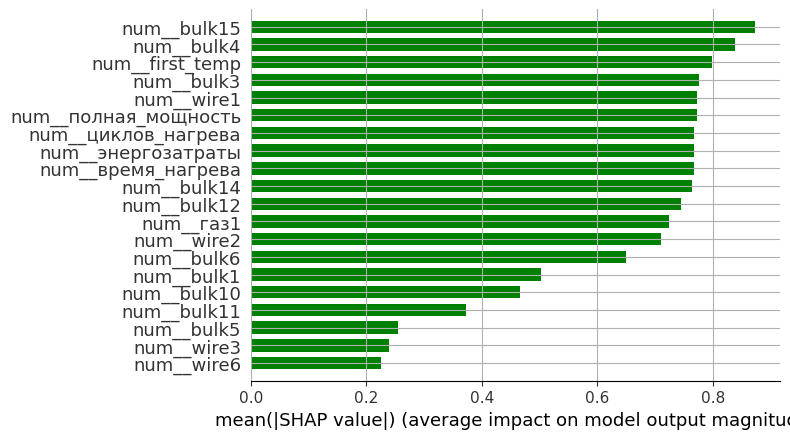

In [107]:
final_calcul(grid_search)

Лучшая модель и её параметры   {'models': LGBMRegressor(random_state=29102024), 'models__eta': 0.3, 'models__learning_rate': 0.1, 'models__max_depth': 20, 'models__min_samples_leaf': 2, 'models__n_estimators': 60, 'preprocessor__num': StandardScaler()} -6.177121400817982
**********************************************************************
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
Первые четыре значения предсказания целевого признака и его значение из тестовой выборки
1592.1576764774804    1591.0
1602.2622859066093    1614.0
1608.2487922059738    1594.0
1593.1319638864686    1586.0
**********************************************************************
R2 лучшей модели LGBMRegressor(eta=0.3, max_depth=20, min_samples_leaf=2, n_estimators=60,
              random_state=29102024) 

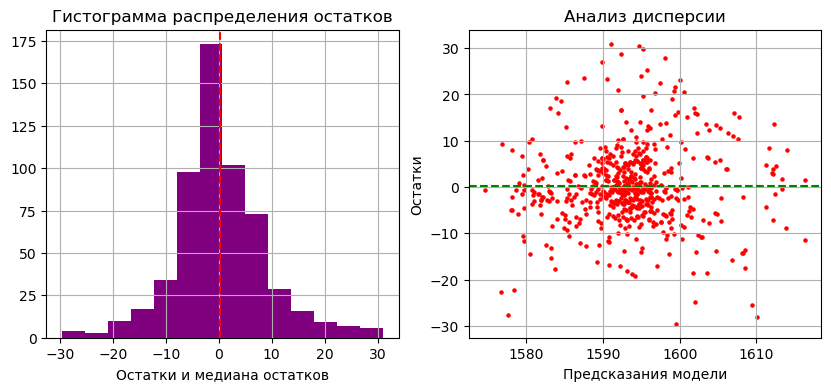

****************************************************************************************************
                                         АНАЛИЗ  ВАЖНОСТИ ПРИЗНАКОВ
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=2. Current value: min_data_in_leaf=2
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.3 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 27
[LightGBM] [Info] Start training from

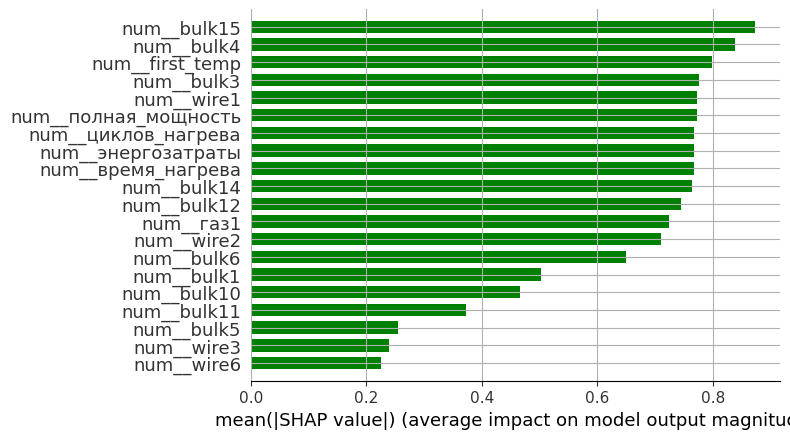

In [120]:
#from scipy import stats as st
#import shap
#from sklearn.metrics import (r2_score, roc_auc_score, f1_score, fbeta_score, accuracy_score,
# recall_score, make_scorer, precision_score, mean_absolute_error,
                            #mean_squared_error, root_mean_squared_error)

# Лучшие параметры и оценка для дерева решений
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшая модель и её параметры  ", best_params, best_score)

print("*"*70)
# обучите модель на тренировочных данных
#grid_search.fit(X_train, y_train)

# получите предсказания модели на тестовых данных 
# сохраните результат в переменную predictions
predictions = grid_search.predict(X_test)

print("Первые четыре значения предсказания целевого признака и его значение из тестовой выборки")
print(predictions[0], "  ", y_test.reset_index(drop = True)[0])
print(predictions[1], "  ", y_test.reset_index(drop = True)[1])
print(predictions[2], "  ", y_test.reset_index(drop = True)[2])
print(predictions[3], "  ", y_test.reset_index(drop = True)[3])
print("*"*70)

r2 =  r2_score(y_test, predictions)  

# выведите полученное значение R2
print(f"R2 лучшей модели {grid_search.best_estimator_.named_steps['models']} = {r2:.6f}")

mae = mean_absolute_error(y_test, predictions)
print(f'MAE = {mae:.2f}')

mse = mean_squared_error(y_test, predictions) 
print(f'MSE = {mse:.2f}')

rmse = root_mean_squared_error( y_test, predictions)
print(f'RMSE = {rmse:.2f}')
print("*"*70)

print(f"Среднее предсказанное значение - {predictions.mean():.4f}")
print("*"*70)   

predictions2 = pd.Series(predictions, index=y_test.index)
test_y2 = y_test

zapas_sr2 = predictions.mean()
sigma2 = rmse
#*******************************************************   
residuals = y_test - predictions
print(f"Интервал остатков от {residuals.min():.4f} до {residuals.max():.4f}")
    
conf_int = st.t.interval(
0.95, len(residuals)-1, residuals.mean(), scale=st.sem(residuals))

print(f"Доверительный интервал '0.95' от {conf_int[0]:.4f} до {conf_int[1]:.4f}")   
print("*"*100)    
print()

    
print("                                         АНАЛИЗ  ОСТАТКОВ")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axes[0].hist(residuals,
             bins=14,
             color = "purple")
axes[0].axvline(x=residuals.mean(), color='red', linestyle='--')
axes[0].grid(True)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки и медиана остатков')

axes[1].scatter(x=predictions, y=residuals, s= 5, color = "red")
axes[1].axhline(y=residuals.mean(), color='green', linestyle='--')
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.grid(True)
plt.show()
print("*"*100)
print("                                         АНАЛИЗ  ВАЖНОСТИ ПРИЗНАКОВ")
X_encoded_1 = grid_search.best_estimator_['preprocessor'].fit_transform(X_train)

model_1 = grid_search.best_estimator_['models'].fit(X_encoded_1, y_train)
explainer_1 = shap.PermutationExplainer(model_1, X_encoded_1)

labels_1 = grid_search.best_estimator_[:-1].get_feature_names_out()
plt.grid(True)

shap.summary_plot(X_encoded_1, plot_type='bar', feature_names=labels_1, color = "green",
                     plot_size=(8,4.5))


## 6. Выводы.
В результате проделанной работы была разработана модель предсказания температуры расплава в зависимости от числа и вида техно логических операций над ним. В итоге лучшей оказалась модель LGBMRegressor с параметрами:
'models__eta': 0.3,

'models__learning_rate': 0.1,

'models__max_depth': 20,

'models__min_samples_leaf': 2,

'models__n_estimators': 60,

'preprocessor__num': StandardScaler()}

Метрика МАЕ для лучшей модели:
 -6.177121400817982.
 
 На тестовой выборке:

Первые четыре значения предсказания целевого признака и его значение из тестовой выборки

1592.1576764774804 ---   1591.0

1602.2622859066093 ---   1614.0

1608.2487922059738 ----   1594.0

1593.1319638864686   --- 1586.0
**********************************************************************
R2 лучшей модели LGBMRegressor = 0.415114

MAE = 6.24

MSE = 74.48

RMSE = 8.63
**********************************************************************
Среднее предсказанное значение - 1593.3669
**********************************************************************
Интервал остатков от -29.5377 до 30.9570
Доверительный интервал '0.95' от -0.4749 до 0.9323
 

Дисперсия остатков равномерная.

Наиболее важные признаки - "bulk15", "bulk14", "first_temp", bulk3", 'wire1', "полная мощность", "циклов нагрева", , "энергозатраты", "время нагрева", "bulk14".